In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import datetime
import os
import joblib

# --- Machine Learning ---
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Notebook Settings ---
%matplotlib inline
sns.set_style('whitegrid')
print("Libraries imported successfully.")

Libraries imported successfully.


In [11]:
# --- File and Data Constants ---
DATA_FILE_PATH = "/workspaces/team-2-abb-hackathon/dataset/train_numeric.csv"
MODEL_SAVE_PATH = "xgboost_model.joblib"
CURVES_SAVE_PATH = "training_curves.json"
ID_COLUMN = "Id"
TARGET_COLUMN = "Response"
TIMESTAMP_COLUMN = "synthetic_timestamp"

# --- Memory Management Constants ---
# Using a smaller sample for initial feature selection to manage memory
CHUNK_SIZE = 100000
SAMPLE_FRACTION = 0.05

N_TOP_FEATURES = 100  # Select only the top N most important features
DATA_SAMPLE_FRACTION = 0.20  # Use only 20% of the total data for training/testing

SYNTHETIC_DATA_START_DATE = datetime.datetime(2023, 1, 1, 0, 0, 0)

print("Constants defined.")

Constants defined.


In [3]:
# --- Determine the total number of rows to calculate the full timestamp range ---
print("Calculating total rows to determine time splits...")
total_rows = sum(1 for row in open(DATA_FILE_PATH, "r")) - 1  # Subtract 1 for header
print(f"Total original data rows found: {total_rows}")

# --- Calculate the number of rows in the final sampled dataset ---
sampled_total_rows = int(total_rows * DATA_SAMPLE_FRACTION)
print(f"Total rows after sampling ({DATA_SAMPLE_FRACTION*100}%): {sampled_total_rows}")

# --- Programmatically Determine Time Splits for a 60-20-20 Ratio ---
print("\nProgrammatically determining time periods for a 60-20-20 split...")

# Total duration in seconds is equal to the number of rows in our final dataset
duration_in_seconds = sampled_total_rows

# Calculate the end point (in seconds from the start) for each period
train_duration_sec = int(duration_in_seconds * 0.60)
test_duration_sec = int(duration_in_seconds * 0.20)

# Define the absolute start and end times for the entire sampled dataset
DATASET_START_TIME = SYNTHETIC_DATA_START_DATE
DATASET_END_TIME = DATASET_START_TIME + datetime.timedelta(
    seconds=duration_in_seconds - 1
)

# Calculate the specific start and end datetimes for each period
TRAINING_PERIOD_START = DATASET_START_TIME
TRAINING_PERIOD_END = TRAINING_PERIOD_START + datetime.timedelta(
    seconds=train_duration_sec - 1
)

TESTING_PERIOD_START = TRAINING_PERIOD_END + datetime.timedelta(seconds=1)
TESTING_PERIOD_END = TESTING_PERIOD_START + datetime.timedelta(
    seconds=test_duration_sec - 1
)

SIMULATION_PERIOD_START = TESTING_PERIOD_END + datetime.timedelta(seconds=1)
SIMULATION_PERIOD_END = DATASET_END_TIME  # The rest of the data

print("\n--- Calculated Time Periods ---")
print(f"Training:   {TRAINING_PERIOD_START} -> {TRAINING_PERIOD_END}")
print(f"Testing:    {TESTING_PERIOD_START} -> {TESTING_PERIOD_END}")
print(f"Simulation: {SIMULATION_PERIOD_START} -> {SIMULATION_PERIOD_END}")
print("-----------------------------\n")

# --- Validate the defined period constants ---
print("Validating calculated time periods...")
try:
    assert (
        TRAINING_PERIOD_START <= TRAINING_PERIOD_END
    ), "Training start must be <= training end."
    assert (
        TESTING_PERIOD_START <= TESTING_PERIOD_END
    ), "Testing start must be <= testing end."
    assert (
        SIMULATION_PERIOD_START <= SIMULATION_PERIOD_END
    ), "Simulation start must be <= simulation end."

    assert (
        TRAINING_PERIOD_END < TESTING_PERIOD_START
    ), "Testing period must start after training period ends."
    assert (
        TESTING_PERIOD_END < SIMULATION_PERIOD_START
    ), "Simulation period must start after testing period ends."

    assert (
        TRAINING_PERIOD_START >= DATASET_START_TIME
    ), "Training start date is before the dataset's start."
    assert (
        SIMULATION_PERIOD_END <= DATASET_END_TIME
    ), "Simulation end date is after the dataset's end."

    print("All time period validations passed successfully!")
except AssertionError as e:
    print(f"Validation Error: {e}")

Calculating total rows to determine time splits...
Total original data rows found: 1183747
Total rows after sampling (20.0%): 236749

Programmatically determining time periods for a 60-20-20 split...

--- Calculated Time Periods ---
Training:   2023-01-01 00:00:00 -> 2023-01-02 15:27:28
Testing:    2023-01-02 15:27:29 -> 2023-01-03 04:36:37
Simulation: 2023-01-03 04:36:38 -> 2023-01-03 17:45:48
-----------------------------

Validating calculated time periods...
All time period validations passed successfully!


In [4]:
print("Starting feature selection using a data sample...")

# Read the data in chunks and sample from each chunk
chunks = pd.read_csv(DATA_FILE_PATH, chunksize=CHUNK_SIZE)
sample_df_list = []

for chunk in chunks:
    sample_df_list.append(chunk.sample(frac=SAMPLE_FRACTION, random_state=42))

# Concatenate all samples into a single DataFrame
sample_df = pd.concat(sample_df_list)
print(f"Sampled DataFrame created with {len(sample_df)} rows.")

# Prepare data for the preliminary model
X_sample = sample_df.drop(columns=[ID_COLUMN, TARGET_COLUMN])
y_sample = sample_df[TARGET_COLUMN]

# Train a preliminary XGBoost model to get feature importances
print("Training preliminary XGBoost model on the sample...")
prelim_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
prelim_model.fit(X_sample, y_sample)

# Get feature importances and select the most important ones
importances = prelim_model.feature_importances_
# Get the indices of the features sorted by importance (descending)
indices = np.argsort(importances)[::-1]
# Select the names of the top N features
important_features = X_sample.columns[indices[:N_TOP_FEATURES]]

print(
    f"\nSelected the top {len(important_features)} most important features (out of {len(X_sample.columns)})."
)
# We must always include the ID and Target columns for processing
cols_to_load = [ID_COLUMN, TARGET_COLUMN] + list(important_features)

Starting feature selection using a data sample...
Sampled DataFrame created with 59187 rows.
Training preliminary XGBoost model on the sample...


/opt/python/3.13.5/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:29:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Selected the top 100 most important features (out of 968).


In [5]:
print(
    f"Loading {DATA_SAMPLE_FRACTION*100}% of the dataset with the top {N_TOP_FEATURES} features..."
)

# 1. Read the data in chunks, sampling from each chunk to reduce memory usage
sampled_chunks = []
for chunk in pd.read_csv(DATA_FILE_PATH, usecols=cols_to_load, chunksize=CHUNK_SIZE):
    sampled_chunks.append(chunk.sample(frac=DATA_SAMPLE_FRACTION))

# 2. Concatenate the sampled chunks into a single DataFrame
full_sampled_df = pd.concat(sampled_chunks, ignore_index=True)
print(f"Created a single sampled DataFrame with {len(full_sampled_df)} rows.")

# 3. Add the synthetic timestamp column to the sampled data
# NOTE: The timestamp is now relative to the sampled data, not the original row count.
# This is a necessary simplification for memory management. The time-based split remains valid.
start_time = DATASET_START_TIME  # Use the original start time
timestamps = pd.to_datetime(
    [start_time + datetime.timedelta(seconds=i) for i in range(len(full_sampled_df))]
)
full_sampled_df[TIMESTAMP_COLUMN] = timestamps

# 4. Split the single, in-memory DataFrame based on the defined time periods
train_df = full_sampled_df[
    (full_sampled_df[TIMESTAMP_COLUMN] >= TRAINING_PERIOD_START)
    & (full_sampled_df[TIMESTAMP_COLUMN] <= TRAINING_PERIOD_END)
]
test_df = full_sampled_df[
    (full_sampled_df[TIMESTAMP_COLUMN] >= TESTING_PERIOD_START)
    & (full_sampled_df[TIMESTAMP_COLUMN] <= TESTING_PERIOD_END)
]
simulation_df = full_sampled_df[
    (full_sampled_df[TIMESTAMP_COLUMN] >= SIMULATION_PERIOD_START)
    & (full_sampled_df[TIMESTAMP_COLUMN] <= SIMULATION_PERIOD_END)
]

print(f"\nData successfully split from the {DATA_SAMPLE_FRACTION*100}% sample:")
print(f" - Training set size:   {len(train_df)} rows")
print(f" - Testing set size:      {len(test_df)} rows")
print(f" - Simulation set size:   {len(simulation_df)} rows")

# Prepare final training and testing sets
X_train = train_df[important_features]
y_train = train_df[TARGET_COLUMN]

X_test = test_df[important_features]
y_test = test_df[TARGET_COLUMN]

# Clean up to free memory
del full_sampled_df, train_df, test_df, simulation_df
import gc

gc.collect()

Loading 20.0% of the dataset with the top 100 features...
Created a single sampled DataFrame with 236749 rows.

Data successfully split from the 20.0% sample:
 - Training set size:   142049 rows
 - Testing set size:      47349 rows
 - Simulation set size:   47351 rows


67

In [7]:
print("Training the final XGBoost model...")

# Instantiate the final classifier
# We use a custom 'accuracy' metric since XGBoost's default metrics might differ slightly
model = xgb.XGBClassifier(
    n_estimators=200,  # Number of boosting rounds
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    objective="binary:logistic",
    eval_metric=eval_metric,
)

# Define the evaluation set to track performance on the training data
eval_set = [(X_train, y_train)]

# Define evaluation metrics. 'logloss' for loss, 'error' for classification error.
# We will calculate accuracy from 'error' (accuracy = 1 - error)
eval_metric = ["logloss", "error"]

# Train the model
model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False,  # Set to True if you want to see progress during training
)

print("Model training complete.")

# Retrieve the evaluation results
eval_results = model.evals_result()

Training the final XGBoost model...


/opt/python/3.13.5/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:33:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.


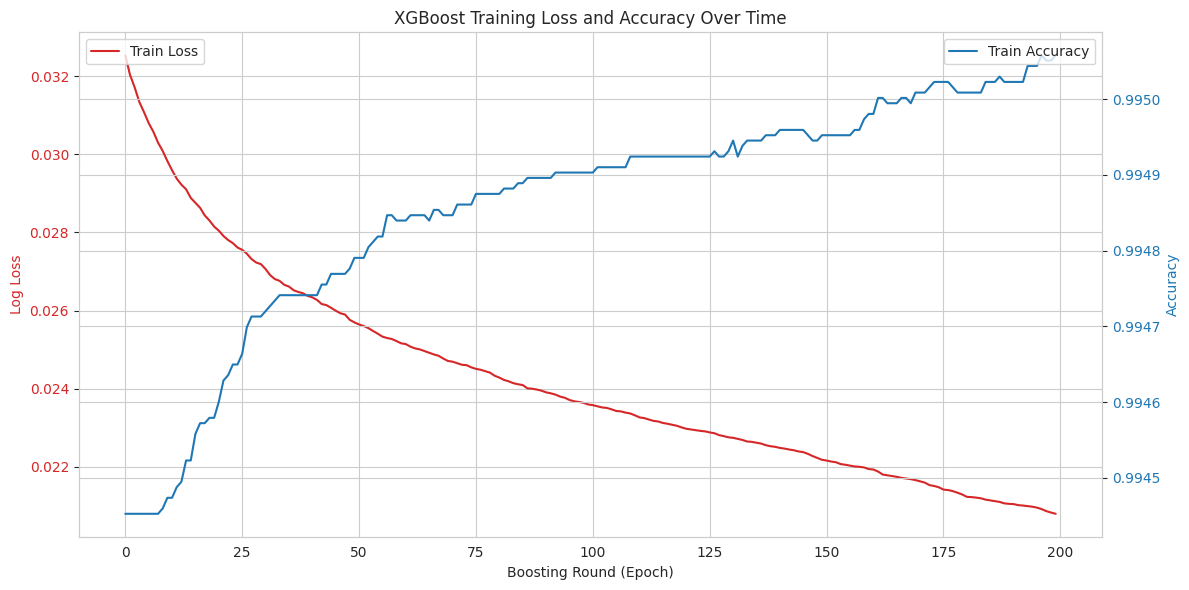

In [8]:
# --- Extract metrics from the results dictionary ---
train_loss = eval_results["validation_0"]["logloss"]
train_error = eval_results["validation_0"]["error"]
train_accuracy = [1 - err for err in train_error]
epochs = len(train_loss)
x_axis = range(0, epochs)

# --- Create the plot ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Training Loss
color = "tab:red"
ax1.set_xlabel("Boosting Round (Epoch)")
ax1.set_ylabel("Log Loss", color=color)
ax1.plot(x_axis, train_loss, color=color, label="Train Loss")
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("Accuracy", color=color)
ax2.plot(x_axis, train_accuracy, color=color, label="Train Accuracy")
ax2.tick_params(axis="y", labelcolor=color)
ax2.legend(loc="upper right")

# --- Final Touches ---
plt.title("XGBoost Training Loss and Accuracy Over Time")
fig.tight_layout()
plt.show()

In [9]:
print("Evaluating model performance on the test set...")

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print("\n--- Test Set Evaluation Metrics ---")
print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-score:   {f1:.4f}")
print("-----------------------------------")

Evaluating model performance on the test set...

--- Test Set Evaluation Metrics ---
Accuracy:   0.9947
Precision:  0.9091
Recall:     0.0385
F1-score:   0.0738
-----------------------------------


In [12]:
# --- Save the training curves plot ---
import json 

try:
    # Structure the data for easy consumption by a frontend/API.
    # The variables train_loss, train_accuracy, and x_axis were defined in Cell 8.
    curves_data = {
        "epochs": list(x_axis),  # The x-axis (boosting rounds)
        "metrics": {"train_loss": train_loss, "train_accuracy": train_accuracy},
    }

    # Write the dictionary to the specified JSON file
    with open(CURVES_SAVE_PATH, "w") as f:
        json.dump(curves_data, f, indent=4)

    print(f"Training curves data successfully saved to '{CURVES_SAVE_PATH}'")

except NameError:
    print(
        "Error: Curve data (e.g., 'train_loss') not found. Make sure Cell 8 has been run."
    )
except Exception as e:
    print(f"An error occurred while saving curves data: {e}")


# --- Save the final trained model ---
try:
    joblib.dump(model, MODEL_SAVE_PATH)
    print(f"Trained XGBoost model saved to '{MODEL_SAVE_PATH}'")
except Exception as e:
    print(f"Error saving model: {e}")

# To load the model later, you would use:
# loaded_model = joblib.load(MODEL_SAVE_PATH)

Training curves data successfully saved to 'training_curves.json'
Trained XGBoost model saved to 'xgboost_model.joblib'
